# Data Exploration and Validation
## Reasoning Distillation Project

This notebook:
1. Downloads e-SNLI dataset
2. Validates data quality and structure
3. Computes statistics
4. Visualizes sample examples

In [1]:
# Setup
import sys
import os
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Imports
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

from src.data.data_loader import (
    TeacherDataLoader,
    DatasetConfig,
)

# Styling
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

%load_ext autoreload
%autoreload 2

## 1. Initialize Data Loader

In [2]:
# Create configuration
config = DatasetConfig(
    raw_data_dir="../data/raw",
    processed_data_dir="../data/processed",
    cache_dir="../data/cache"
)

# Initialize loader
loader = TeacherDataLoader(config)
print("Data loader initialized successfully!")
print(f"Raw data directory: {config.raw_data_dir}")
print(f"Cache directory: {config.cache_dir}")

Data loader initialized successfully!
Raw data directory: ../data/raw
Cache directory: ../data/cache


## 2. Load and Validate e-SNLI Dataset

In [3]:
# Load e-SNLI (all splits)
print("Loading e-SNLI dataset...")
esnli_dataset = loader.load_esnli()

# Display basic info
print(f"\nAvailable splits: {list(esnli_dataset.keys())}")
for split_name, split_data in esnli_dataset.items():
    print(f"  {split_name}: {len(split_data):,} samples")

# Show features
print(f"\nFeatures: {esnli_dataset['train'].features}")

INFO:src.data.data_loader:Loading e-SNLI dataset from GitHub (OanaMariaCamburu/e-SNLI)...


Loading e-SNLI dataset...


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/259999 [00:00<?, ? examples/s]

Map:   0%|          | 0/289368 [00:00<?, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/9842 [00:00<?, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/9824 [00:00<?, ? examples/s]

INFO:src.data.data_loader:✓ Loaded e-SNLI: train=549367, val=9842, test=9824
INFO:src.data.data_loader:e-SNLI loaded successfully. Splits: ['train', 'validation', 'test']
INFO:src.data.data_loader:Sample counts: [('train', 549367), ('validation', 9842), ('test', 9824)]



Available splits: ['train', 'validation', 'test']
  train: 549,367 samples
  validation: 9,842 samples
  test: 9,824 samples

Features: {'premise': Value('string'), 'hypothesis': Value('string'), 'label': Value('int64'), 'explanation_1': Value('string'), 'explanation_2': Value('string'), 'explanation_3': Value('string')}


In [4]:
# Validate e-SNLI
print("Validating e-SNLI dataset...")
esnli_stats = loader.validate_esnli(esnli_dataset)

print("\n=== e-SNLI Validation Statistics ===")
pprint(esnli_stats)

INFO:src.data.data_loader:Validating e-SNLI dataset...


Validating e-SNLI dataset...


Parsing test: 100%|██████████| 9824/9824 [00:00<00:00, 24636.07it/s]
INFO:src.data.data_loader:Validation complete.



=== e-SNLI Validation Statistics ===
{'explanation_stats': {'test': {'max_length': 82,
                                'mean_length': 12.989311889250814,
                                'min_length': 3,
                                'samples_with_explanation': 9824},
                       'train': {'max_length': 154,
                                 'mean_length': 12.3457870603804,
                                 'min_length': 1,
                                 'samples_with_explanation': 549367},
                       'validation': {'max_length': 68,
                                      'mean_length': 12.93019711440764,
                                      'min_length': 3,
                                      'samples_with_explanation': 9842}},
 'label_distribution': {'test': {0: 3368, 1: 3219, 2: 3237},
                        'train': {0: 183416, 1: 182764, 2: 183187},
                        'validation': {0: 3329, 1: 3235, 2: 3278}},
 'splits': {'test': 9824, 'train': 54

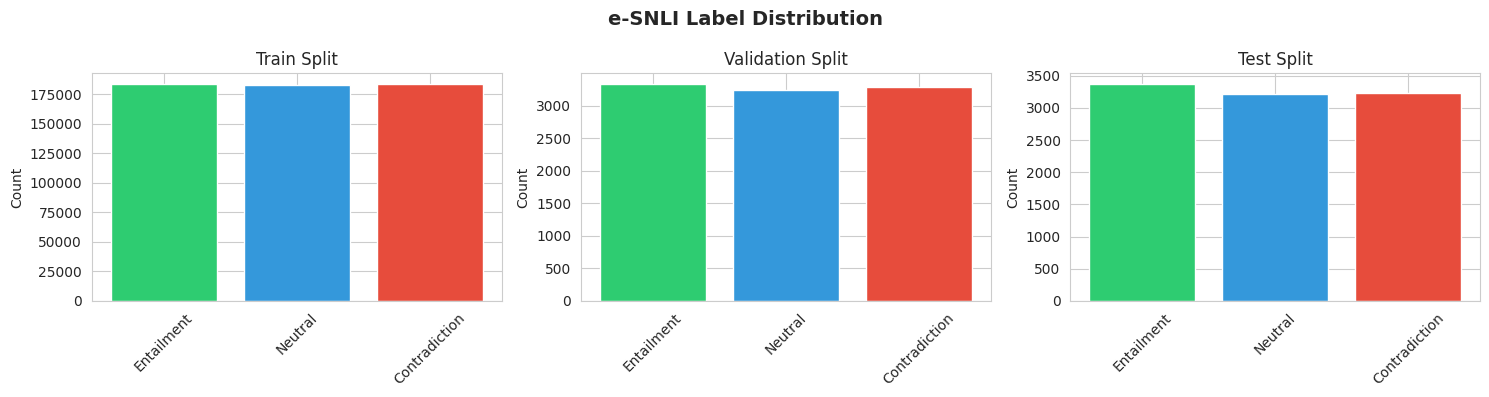

In [5]:
# Visualize label distribution
label_map = {0: 'Entailment', 1: 'Neutral', 2: 'Contradiction'}

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (split_name, label_dist) in enumerate(esnli_stats['label_distribution'].items()):
    labels = [label_map[k] for k in sorted(label_dist.keys())]
    counts = [label_dist[k] for k in sorted(label_dist.keys())]
    
    axes[idx].bar(labels, counts, color=['#2ecc71', '#3498db', '#e74c3c'])
    axes[idx].set_title(f'{split_name.capitalize()} Split')
    axes[idx].set_ylabel('Count')
    axes[idx].tick_params(axis='x', rotation=45)

plt.suptitle('e-SNLI Label Distribution', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

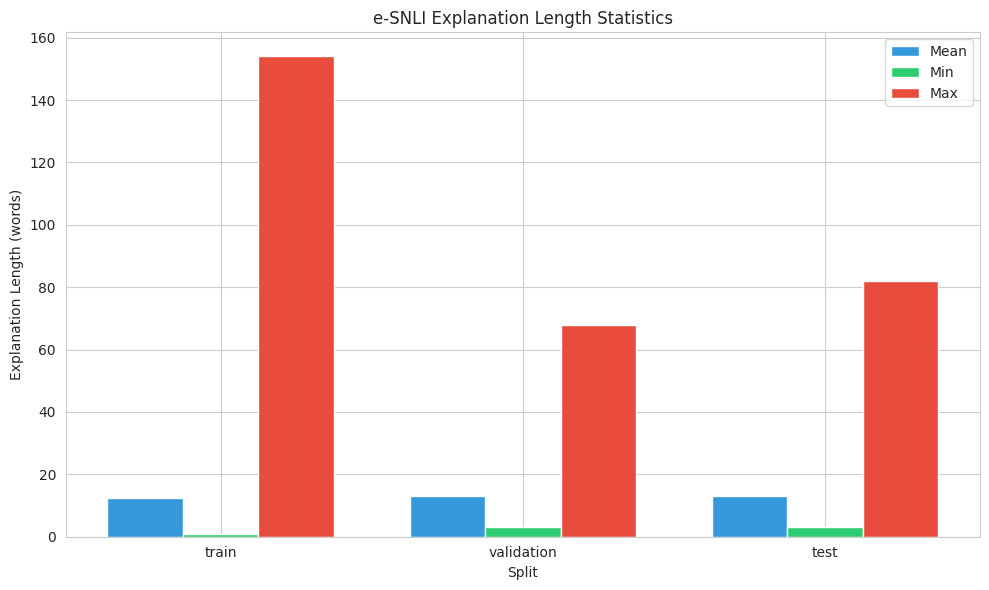

In [6]:
# Visualize explanation lengths
exp_stats = esnli_stats['explanation_stats']

splits = list(exp_stats.keys())
mean_lengths = [exp_stats[s]['mean_length'] for s in splits]
min_lengths = [exp_stats[s]['min_length'] for s in splits]
max_lengths = [exp_stats[s]['max_length'] for s in splits]

x = range(len(splits))
width = 0.25

plt.figure(figsize=(10, 6))
plt.bar([i - width for i in x], mean_lengths, width, label='Mean', color='#3498db')
plt.bar(x, min_lengths, width, label='Min', color='#2ecc71')
plt.bar([i + width for i in x], max_lengths, width, label='Max', color='#e74c3c')

plt.xlabel('Split')
plt.ylabel('Explanation Length (words)')
plt.title('e-SNLI Explanation Length Statistics')
plt.xticks(x, splits)
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
# Display sample e-SNLI examples
print("\n=== Sample e-SNLI Examples ===")
samples = loader.get_sample_examples(esnli_dataset['train'], n_samples=3)

for i, sample in enumerate(samples, 1):
    parsed = loader.parse_esnli_sample(sample)
    print(f"\n--- Example {i} ---")
    print(f"Premise: {parsed['premise']}")
    print(f"Hypothesis: {parsed['hypothesis']}")
    print(f"Label: {label_map[parsed['label']]}")
    print(f"Explanation: {parsed['explanation']}")


=== Sample e-SNLI Examples ===

--- Example 1 ---
Premise: A young girl is floating in a metal tub in a body of water, while holding a snake.
Hypothesis: A young girl resting on a chair.
Label: Contradiction
Explanation: While a young girl is multitasking with a metal tub and holding a snake wouldn't rest on a chair all at once.

--- Example 2 ---
Premise: A large group of bicycle riders riding down the road.
Hypothesis: People skating on the sidewalk.
Label: Contradiction
Explanation: Bicycle riders vs skaters.

--- Example 3 ---
Premise: A woman is walking at dusk down an urban street.
Hypothesis: the street is empty
Label: Neutral
Explanation: One cannot assume that the street that the woman is walking down is empty. It can't be empty if she is there!


## 5. Summary

In [8]:
print("\n" + "="*60)
print("DATA LOADING & VALIDATION SUMMARY")
print("="*60)

print("\ne-SNLI Dataset:")
for split_name in esnli_stats['splits']:
    n = esnli_stats['splits'][split_name]
    exp = esnli_stats['explanation_stats'][split_name]['samples_with_explanation']
    print(f"  • {split_name}: {n:,} samples ({exp:,} with explanations)")


DATA LOADING & VALIDATION SUMMARY

e-SNLI Dataset:
  • train: 549,367 samples (549,367 with explanations)
  • validation: 9,842 samples (9,842 with explanations)
  • test: 9,824 samples (9,824 with explanations)
